In [ ]:
from utils.types import AnonMethod
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from metrics import NCP, DM, CAVG

from algorithms import (k_anonymize,read_tree)
from datasets import get_dataset_params
from utils.data import read_raw, write_anon, numberize_categories

from models import classifier_evaluation
from operator import sub








## Declare ***args*** to store custom parameters

In [ ]:
class arg_def:
    
    method = 'datafly'  #anonymization algorithm
    k = 1               #value of k
    dataset = 'adult'   #dataset


args = arg_def

## Initialize the ***anonymizer*** class with the different input parameters and set directories

In [ ]:

class Anonymizer:
    
    def __init__(self, args):

        self.method = args.method
        self.k = args.k
        self.data_name = args.dataset

#SETTING paths to build dir

        self.csv_path = args.dataset+'.csv'\

        self.path = os.path.join('data', args.dataset) 
        self.data_path = os.path.join(self.path, self.csv_path)

     
        self.gen_path = os.path.join(self.path,'hierarchies')
        res_folder = os.path.join('results', args.dataset, self.method)
        self.anon_folder = res_folder  
        
        os.makedirs(self.anon_folder, exist_ok=True)

    def anonymize(self):
        data = pd.read_csv(self.data_path, delimiter=';')
        ATT_NAMES = list(data.columns)
        
        data_params = get_dataset_params(self.data_name)
        QI_INDEX = data_params['qi_index']
        IS_CAT2 = data_params['is_category']

        QI_NAMES = list(np.array(ATT_NAMES)[QI_INDEX])
        IS_CAT = [True] * len(QI_INDEX) 
        SA_INDEX = [index for index in range(len(ATT_NAMES)) if index not in QI_INDEX]
        #SA_var = [ATT_NAMES[i] for i in SA_INDEX]

        ATT_TREES = read_tree(
            self.gen_path, 
            self.data_name, 
            ATT_NAMES, 
            QI_INDEX, IS_CAT)

        raw_data, header = read_raw(
            self.path, 
            self.data_name, 
            QI_INDEX, IS_CAT)

        anon_params = {
            "name" :self.method,
            "att_trees" :ATT_TREES,
            "value" :self.k,
            "qi_index" :QI_INDEX, 
            "sa_index" :SA_INDEX
        }

        if self.method == AnonMethod.CLASSIC_MONDRIAN:
            mapping_dict,raw_data = numberize_categories(raw_data, QI_INDEX, SA_INDEX, IS_CAT2)
            anon_params.update({'mapping_dict': mapping_dict})
            anon_params.update({'is_cat': IS_CAT2})

        if self.method == AnonMethod.DATAFLY:
            anon_params.update({
                'qi_names': QI_NAMES,
                'csv_path': self.data_path,
                'data_name': self.data_name,
                'dgh_folder': self.gen_path,
                'res_folder': self.anon_folder})

        anon_params.update({'data': raw_data})

        print(f"Anonymize with {self.method}")
        anon_data, runtime = k_anonymize(anon_params)

 
        if anon_data is not None:
            nodes_count = write_anon(
                self.anon_folder, 
                anon_data, 
                header, 
                self.k, 
                self.data_name)

        if self.method == AnonMethod.CLASSIC_MONDRIAN:
            ncp_score, runtime = runtime
        else:
            # Normalized Certainty Penalty
            ncp = NCP(anon_data, QI_INDEX, ATT_TREES)
            ncp_score = ncp.compute_score()

        # Discernibility Metric

        raw_dm = DM(raw_data, QI_INDEX, self.k)
        raw_dm_score = raw_dm.compute_score()

        anon_dm = DM(anon_data, QI_INDEX, self.k)
        anon_dm_score = anon_dm.compute_score()

        # Average Equivalence Class

        raw_cavg = CAVG(raw_data, QI_INDEX, self.k)
        raw_cavg_score = raw_cavg.compute_score()

        anon_cavg = CAVG(anon_data, QI_INDEX, self.k)
        anon_cavg_score = anon_cavg.compute_score()

        print(f"NCP score (lower is better): {ncp_score:.3f}")
        print(f"CAVG score (near 1 is better): BEFORE: {raw_cavg_score:.3f} || AFTER: {anon_cavg_score:.3f}")
        print(f"DM score (lower is better): BEFORE: {raw_dm_score} || AFTER: {anon_dm_score}")
        display(f"Time execution: {runtime:.3f}s")

        return ncp_score, raw_cavg_score, anon_cavg_score, raw_dm_score, anon_dm_score



In [ ]:
def main(args):
    anonymizer = Anonymizer(args)
    anonymizer.anonymize()

In [ ]:
main(args)

In [ ]:
methods = ['mondrian', 'classic_mondrian', 'topdown'] 
dataset = ['adult', 'cahousing', 'cmc', 'mgm', 'informs'] 
k_array = [i for i in range(10, 110, 10)]

metrics = ['ncp', 'cav', 'dm']
ml_metrics = ['knn', 'svm', 'rf']
lcolors = ['orange', 'cyan', 'green', 'magenta']

metric_names = [
    'Normalized\nCertainty\n(lower is better)', 
    'Average\nEquivalence\n(lower is better)', 
    'Discernibility\nMetric\n(lower is better)']

ml_metric_names = [
    'KNN',
    'SVMs',
    'RFs'
]

In [ ]:
def sub_plot(result, dataset, methods, metrics, label_x, label_y, figname):

    fig, axis = plt.subplots(nrows = len(metrics), ncols = len(dataset), figsize = (35, 30))
    
    for row, metric in enumerate(metrics):
        for col, data in enumerate(dataset):
            data = data.encode('utf-8')
            sub_data = result[ (data == result['data']) ]
            for i, method in enumerate(methods):
                method = method.encode('utf-8')
                sub = sub_data[ (method == sub_data['method'])]
                axis[row, col].plot(sub['k'], sub[metric], color = lcolors[i], label=sub[args.method].decode('utf-8'))

    labels_handles = {
        label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
    }

    fig.legend(
        labels_handles.values(),
        labels_handles.keys(),
        loc="upper center",
        fontsize=30,
        ncol=len(labels_handles.values()))

    for ax, col in zip(axis[0], label_x):
        ax.set_title(col.upper(), size=20)
    
    for ax in axis[-1]:
        ax.set_xlabel('k', size=20)

    for ax, row in zip(axis[:,0], label_y):
        ax.set_ylabel(row, size = 30)
        ax.get_yaxis().set_label_coords(-0.2, 0.5)
    
    plt.subplots_adjust(0.075, 0.05, 0.97, 0.95, 0.2, 0.25)
    plt.savefig(figname)
    plt.show()

In [67]:
def sub_plot_ml(result, dataset, methods, models, label_x, label_y, figname):

    fig, axis = plt.subplots(nrows = len(models), ncols = len(dataset), figsize = (35, 30))
    
    for col, model in enumerate(models):
        model = model.encode('utf-8')
        sub_data1 = result[(model == result['model'])] 
        for row, data in enumerate(dataset):
            data = data.encode('utf-8')
            sub_data2 = sub_data1[(data == sub_data1['data'])]

            for i, method in enumerate(methods):
                method = method.encode('utf-8')
                sub_data3 = sub_data2[(method == sub_data2['method'])]
                if i == 0:
                    # Baseline score
                    axis[col, row].plot(sub_data3['k'], sub_data3["ori_f1"], '--', color = 'black', label="Baseline")
                axis[col, row].plot(sub_data3['k'], sub_data3["anon_f1"], color = lcolors[i], label= sub_data3[args.method].decode('utf-8'))
            
    labels_handles = {
        label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
    }

    fig.legend(
        labels_handles.values(),
        labels_handles.keys(),
        loc="upper center",
        fontsize=30,
        ncol=len(labels_handles.values()))

    for ax, col in zip(axis[0], label_x):
        ax.set_title(col.upper(), size=20)
    
    for ax in axis[-1]:
        ax.set_xlabel('k', size=20)

    for ax, row in zip(axis[:,0], label_y):
        ax.set_ylabel(row, size = 30)
        ax.get_yaxis().set_label_coords(-0.2, 0.5)
    
    plt.subplots_adjust(0.075, 0.05, 0.97, 0.95, 0.2, 0.25)
    plt.savefig(figname)
    plt.show()

In [68]:
def plot_metric(col, dataset, methods, metrics, label_x, label_y, figname):
    result = np.genfromtxt("metric_result", names = col, dtype = None)
    sub_plot(result, dataset, methods, metrics, label_x, label_y, figname)

def plot_metric_ml(col, dataset, methods, models, label_x, label_y, figname):
    result = np.genfromtxt("ml_metric_result", names = col, dtype=None)
    sub_plot_ml(result, dataset, methods, models, label_x, label_y, figname)


In [69]:
def run_anon_data():

    output = open("metric_result", "w")

    for data in dataset:
        for method in methods:
            for k in k_array:
                args = Namespace()
                args.method = method
                args.dataset = data
                args.k = k
                anonymizer = Anonymizer(args)
                ncp, cav_b, cav_a, dm_b, dm_a = anonymizer.anonymize()
                result = f'{data} {method} {k} {ncp:.3f} {cav_a:.3f} {dm_a:.3f}'
                output.write(result + '\n')
    
    output.close()

In [70]:
def run_anon_data_ml():
    import pandas as pd
    data_path = './data'
    result_path = './results'
    output = open("ml_metric_result", "w")

    data = args.dataset
    method = args.method
    k = args.k

   
    gen_path = f'./data/{data}/hierarchies'
    data_params = get_dataset_params(data)
    QI_INDEX = data_params['qi_index']
    IS_CAT = data_params['is_category']
    HAS_HIERARCHIES = [True] * len(IS_CAT)
    ori_csv = os.path.join(data_path, data, f'{data}.csv')
    tmp_df = pd.read_csv(ori_csv, delimiter=';')
    ATT_NAMES = list(tmp_df.columns)
    ATT_TREES = read_tree(
            gen_path, 
            data, 
            ATT_NAMES, 
            QI_INDEX, 
            HAS_HIERARCHIES)
    train_index = os.path.join(data_path, data, f'{data}_train.txt')
    val_index = os.path.join(data_path, data, f'{data}_val.txt')
    for classifier_name in ml_metrics:
        ori_f1 = classifier_evaluation(classifier_name, ori_csv, train_index, val_index, QI_INDEX, IS_CAT)
       
    
        anon_csv = os.path.join(result_path, data, method, f'{data}_anonymized_{k}.csv')
        tmp_att_trees = ATT_TREES
        
        if method == 'classic_mondrian':
            tmp_att_trees = None
        anon_f1 = classifier_evaluation(
            classifier_name, 
            ori_csv, 
            train_index, 
            val_index, 
            anon_csv=anon_csv,
            qi_index=QI_INDEX, 
            is_cat=IS_CAT,
            att_trees=tmp_att_trees)

        result = f'{data} {method} {k} {classifier_name} {ori_f1:.3f} {anon_f1:.3f}'
        output.write(result + '\n')

    output.close()


Fitting model on original dataset
Replacing all generalized values...


30162it [00:02, 11744.02it/s]


Fitting model on anonymized dataset
Fitting model on original dataset
Replacing all generalized values...


30162it [00:04, 6932.20it/s]


Fitting model on anonymized dataset
Fitting model on original dataset
Replacing all generalized values...


30162it [00:03, 9980.81it/s] 


Fitting model on anonymized dataset


C:\Users\asimj\AppData\Local\Temp\ipykernel_15532\1131983562.py:6: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  result = np.genfromtxt("ml_metric_result", names = col, dtype=None)


AttributeError: 'numpy.ndarray' object has no attribute 'decode'

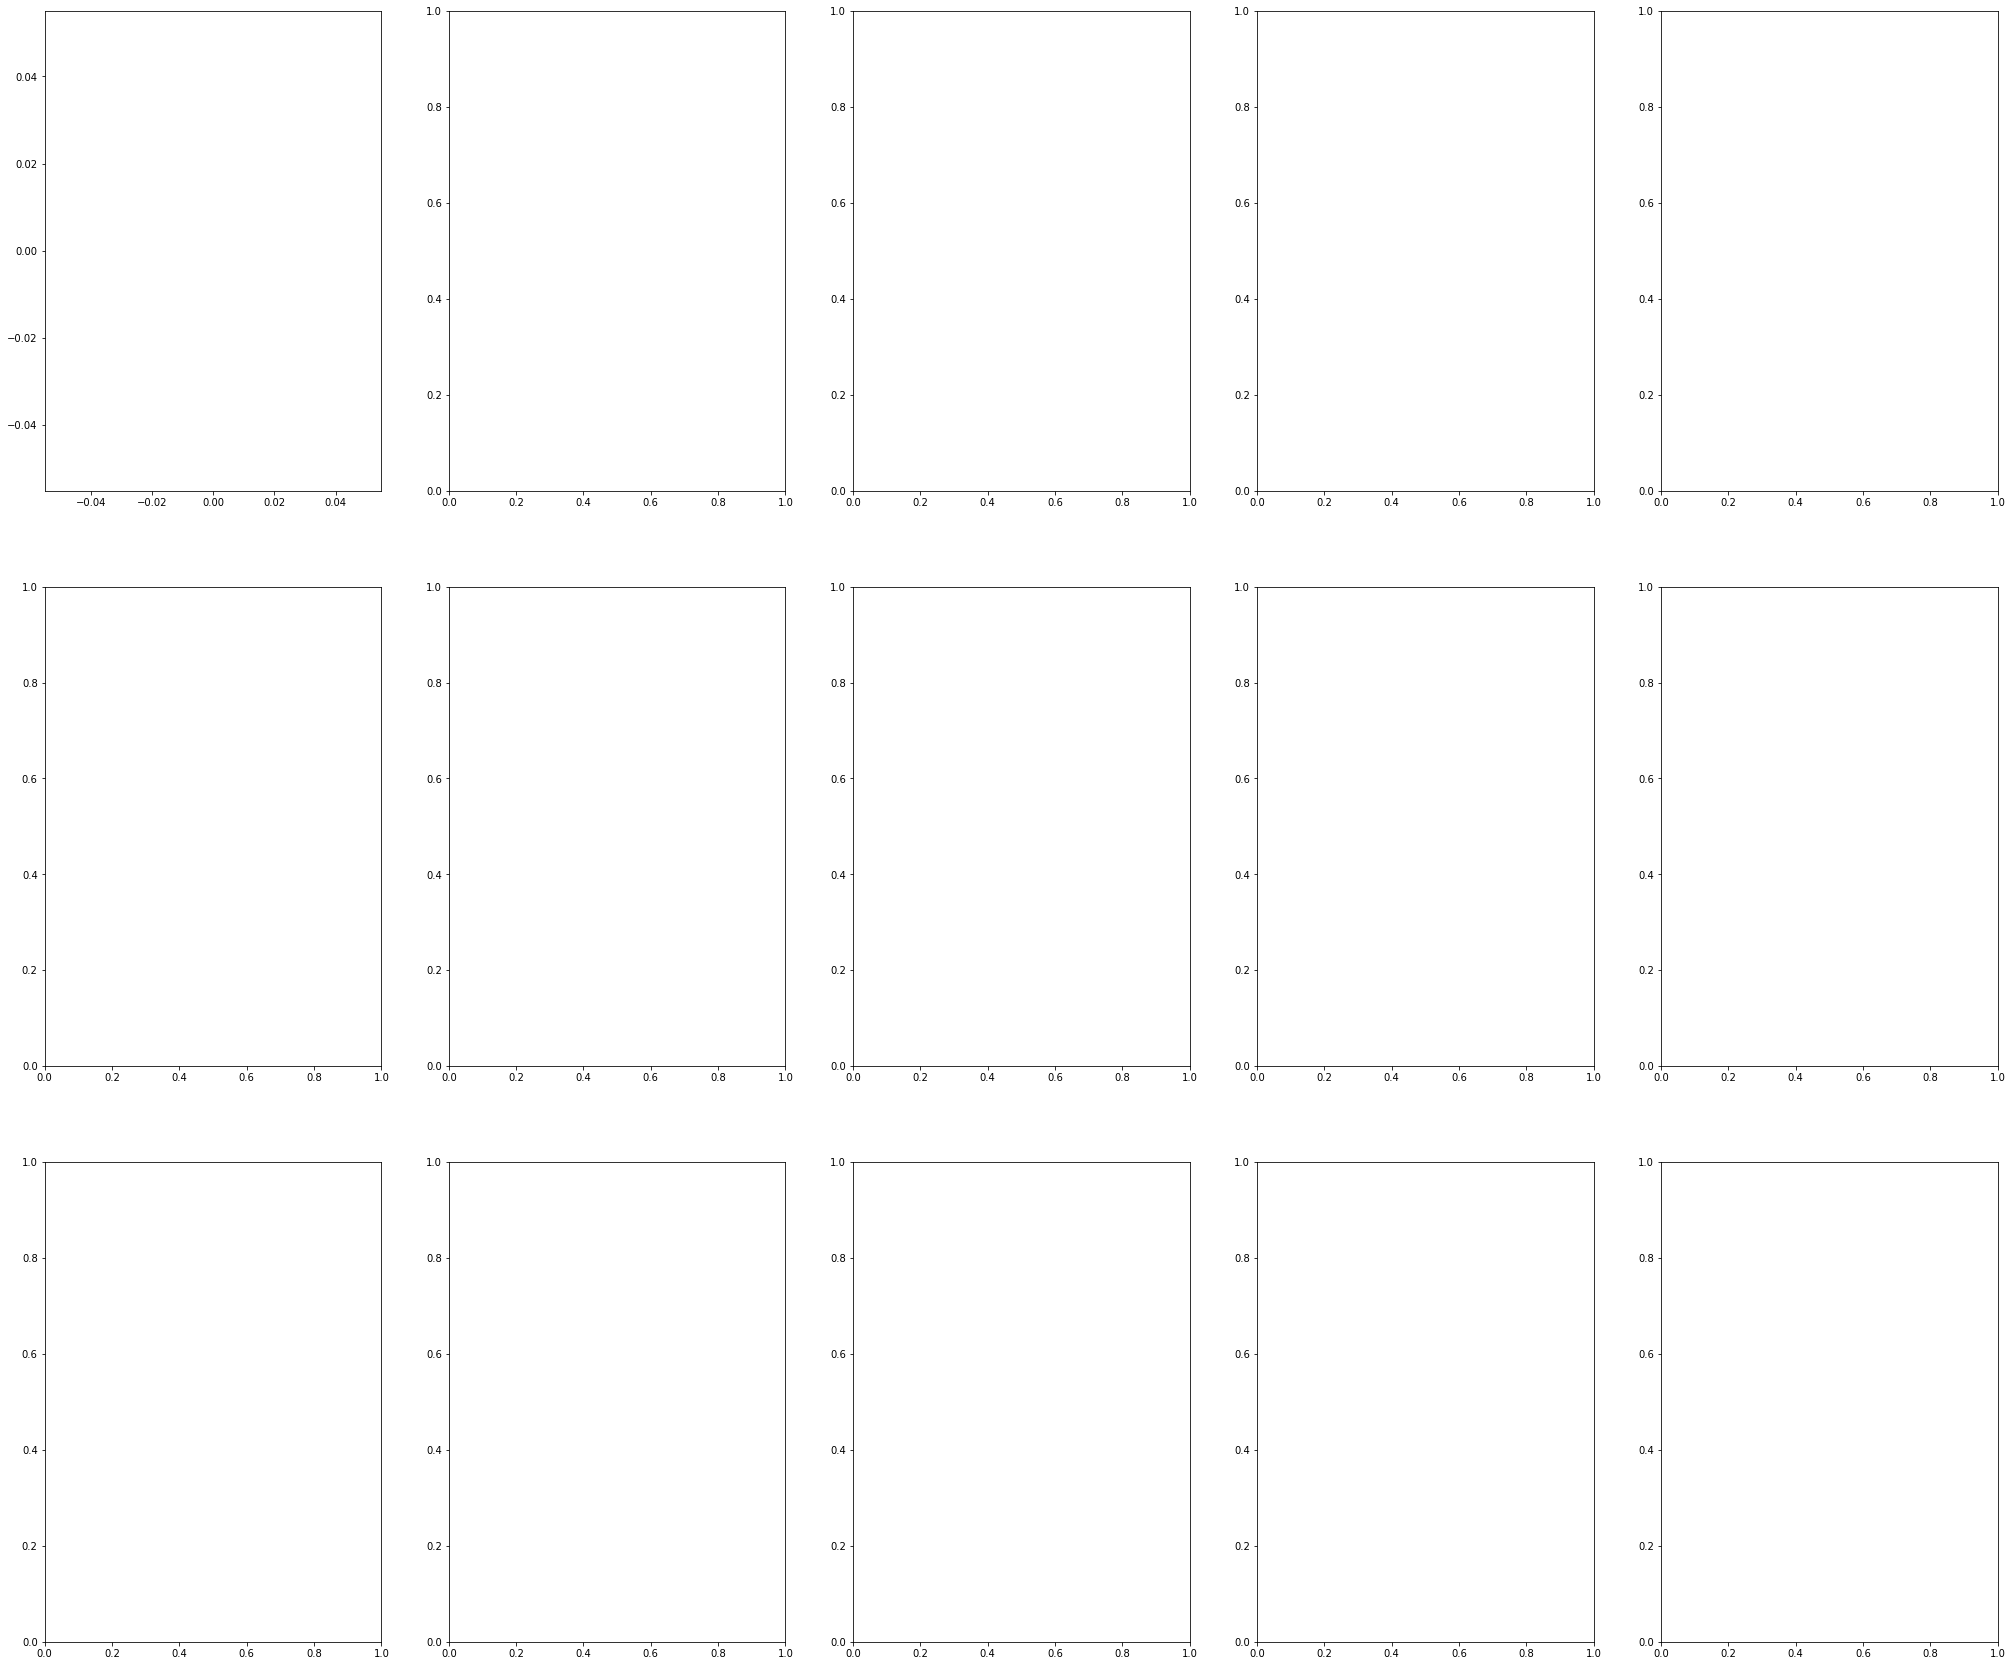

In [71]:

run_anon_data_ml()
plot_metric_ml(
    col = ["data", "method", "k", "model" ,"ori_f1", "anon_f1"],
    dataset=dataset,
    methods=methods,
    models=ml_metrics,
    label_x= dataset,
    label_y = ml_metric_names,
    figname='./demo/metrics_ml'
)